In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def generate_observations(true_w, num, variance):
    """Generate dataset for logistic regression
    
    Parameters:
    true_w   -- the true logistic regression weights
    num      -- the number of data points to generate
    variance -- the multivariate normal variance for X
    """
    d = len(true_w)
    X = np.random.multivariate_normal(np.zeros(d), variance * np.identity(d), size=num)
    z = np.exp(X @ true_w)
    probs = z / (1+z)
    y = np.random.rand(num) < probs
    return X, y.astype(int), true_w

Note the log_liklihood does not include the $p(\vec{x})$ term, it's just $p(y|\vec{x})$

In [28]:
def log_likelihood(X, y, w):
    z = X@w
    return (y*z - np.log(1 + np.exp(z))).sum()

def grad_log_likelihood(X, y, w):
    z = np.exp(X@w)
    t = y - (z/(1+z))
    return (X*t[:,np.newaxis]).sum(axis=0)

In [29]:
def get_step(X, y, w):
    step = 1
    alpha = 0.7
    grad = grad_log_likelihood(X, y, w)
    ll = log_likelihood(X, y, w)
    while log_likelihood(X, y, w + step*grad) < ll + (alpha*step*np.linalg.norm(grad, ord=2)):
        step = 0.8*step
    return step

In [283]:
def do_gd(X, y, true_w, lr=0.001, max_iter=100):
    vals = []
    grads = []
    mse = []
    w = np.zeros(X.shape[1])
    grad = grad_log_likelihood(X, y, w)
    count = 0
    step = 1
    while (len(vals) < 2 or np.abs(vals[-1] - vals[-2]) > 1e-3) and count < max_iter:
        vals.append(log_likelihood(X, y, w))
        grads.append(np.linalg.norm(grad))
        mse.append(np.linalg.norm(w - true_w, ord=2))
        step = get_step(X, y, w)
        w += step*grad
        grad = grad_log_likelihood(X, y, w)
        count += 1        
    return w, vals, grads, mse

## Generate Observations

Choose a true weight vector $\vec{w}$ and generate the corresponding observations.

In [310]:
dimensions = 2
num_observations = 1000
X_variance = 1
w = (5/np.sqrt(2))*np.array([1, 1])

X, y, w = generate_observations(w, num_observations, X_variance)

## Perform Gradient Descent

In [311]:
w_calc, vals, grads, mse = do_gd(X, y, w, lr=0.0001, max_iter=1000)

## Plot Results

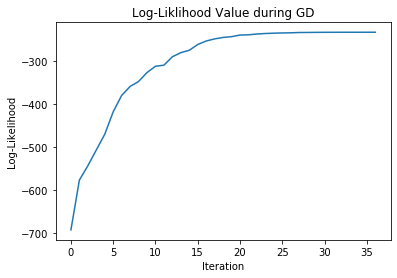

In [320]:
plt.plot(vals)
plt.title("Log-Liklihood Value during GD")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.savefig("val.png")

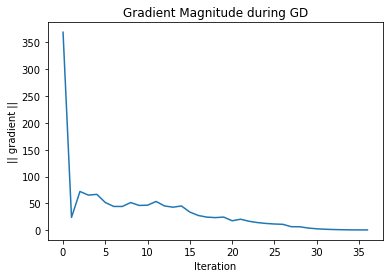

In [317]:
plt.plot(grads)
plt.title("Gradient Magnitude during GD")
plt.xlabel("Iteration")
plt.ylabel("|| gradient ||");

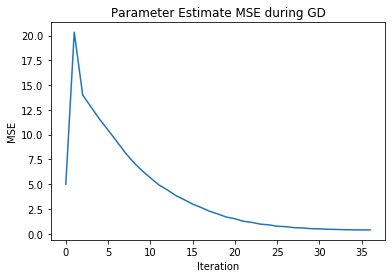

In [321]:
plt.plot(mse)
plt.title("Parameter Estimate MSE during GD")
plt.xlabel("Iteration")
plt.ylabel("MSE");
plt.savefig("mse.png")

In [315]:
mse[-1]

0.37842777827349233

In [290]:
print("True w     Calc w")
for i in range(len(w)):
    print("{:.4f}     {:.4f}".format(w[i], w_calc[i]))

True w     Calc w
3.5355     5.0261
3.5355     3.4359


## Numerically Compute CRLB

In [291]:
def crlb(n, w, X_variance):
    X, y, w = generate_observations(w, 100000, X_variance)
    d = X.shape[1]
    z = np.exp(X@w)
    p = z/(1+z)
    I = np.zeros((d, d))
    for i in range(len(X)):
        x = X[i][:,np.newaxis]
        I += p[i] * (1-p[i]) * x @ x.T
    I /= 100000
    return np.linalg.inv(n*I)

## Compute Covariance for Estimated Parameters

In [385]:
def run_monte_carlo(num_observations, X_variance, mode='gd', lr=0.001, max_iter=1000):
    dimensions = 2
    w = (5/np.sqrt(2))*np.array([1, 1])
    trials = 300
    count = 0

    mse_mat = np.zeros((dimensions, dimensions))
    for i in range(trials):
        X, y, w = generate_observations(w, num_observations, X_variance)

        if mode=='gd':
            w_calc, vals, grads, mse = do_gd(X, y, w, lr, max_iter)
        elif mode =='newton':
            w_calc, _, _,_, _ = do_newton(X, y, w, lr, max_iter)
        else:
            raise NotImplemented
        if (np.any(np.isnan(w_calc))):
            print("Invalid")
            continue
        e = w - w_calc
        if (np.linalg.norm(e, ord=2) > 50):
            continue
        count += 1
        mse_mat += e[:,np.newaxis] @ e[:,np.newaxis].T

    mse_mat /= count
    return (np.trace(mse_mat), np.trace(crlb(num_observations, w, X_variance)))

In [298]:
X_variance = 10
ns = [100, 200, 300, 500, 1000, 2000, 5000, 10000]
mses10 = []
crlbs10 = []
for n in ns:
    print(n, flush=True)
    m, c = run_monte_carlo(n, X_variance, max_iter=500)
    mses10.append(m)
    crlbs10.append(c)

100
200
300
500
1000
2000
5000
10000


In [308]:
X_variance = 1
ns = [100, 200, 300, 500, 1000, 2000, 5000, 10000]
mses1 = []
crlbs1 = []
for n in ns:
    print(n, flush=True)
    m, c = run_monte_carlo(n, X_variance, max_iter=1000)
    mses1.append(m)
    crlbs1.append(c)

100
200
300
500
1000
2000
5000
10000


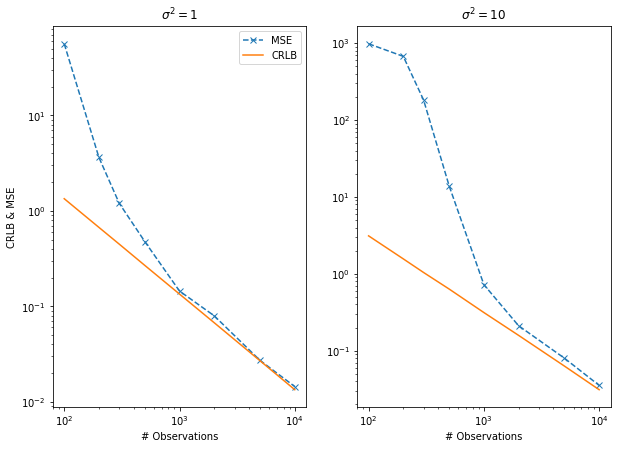

In [309]:
_, (l, r) = plt.subplots(1, 2, figsize=(10,7))

l.plot(ns, mses1, 'x--', label="MSE")
l.plot(ns, crlbs1, label="CRLB")
l.set_title("$\sigma^2 = 1$")
l.set_xlabel("# Observations")
l.set_ylabel("CRLB & MSE")
l.legend()
l.set_xscale('log')
l.set_yscale('log')

r.plot(ns, mses10, 'x--', label="MSE")
r.plot(ns, crlbs10, label="CRLB")
r.set_title("$\sigma^2 = 10$")
r.set_xlabel("# Observations")
r.set_xscale('log')
r.set_yscale('log')

plt.savefig("gd_mse.png")

# Newton Method 

In [322]:
def second_grad_log_likelihood(X, w):
    d = X.shape[1]
    z = np.exp(X @ w)
    p = z / (1 + z)
    I = np.zeros((d, d))
    for i in range(len(X)):
        x = X[i][:, np.newaxis]
        I += p[i] * (1 - p[i]) * x @ x.T
    return I

In [342]:
def do_newton(X, y, true_w, lr=0.001, max_iter=1000):
    vals = []
    grads, second_grads = [], []
    mse = []
    w = np.zeros(X.shape[1])
    grad = grad_log_likelihood(X, y, w)
    second_grad = second_grad_log_likelihood(X, w)
    second_grad_inv = np.linalg.inv(second_grad)

    count = 0
    while (len(vals) < 2 or np.abs(vals[-1] - vals[-2]) > 1e-4) and count < max_iter:
        vals.append(log_likelihood(X, y, w))

        grads.append(np.linalg.norm(grad))
        second_grads.append(np.linalg.norm(second_grad))

        mse.append(np.linalg.norm(w - true_w, ord=2))
        w += lr * (second_grad_inv @ grad)

        grad = grad_log_likelihood(X, y, w)
        second_grad = second_grad_log_likelihood(X, w)
        second_grad_inv = np.linalg.inv(second_grad)
        count += 1
    return w, vals, grads, second_grads, mse

In [372]:
dimensions = 2
num_observations = 30
X_variance = 1
w = (5/np.sqrt(2))*np.array([1, 1])

X, y, w = generate_observations(w, num_observations, X_variance)

w_calc, vals, grads, second_grads, mse = do_newton(X, y, w, lr=0.001, max_iter=10000)

# Plot Results of Newton Method



In [373]:
print("True w     Calc w")
for i in range(len(w)):
    print("{:.4f}     {:.4f}".format(w[i], w_calc[i]))

True w     Calc w
3.5355     6.8084
3.5355     7.9169


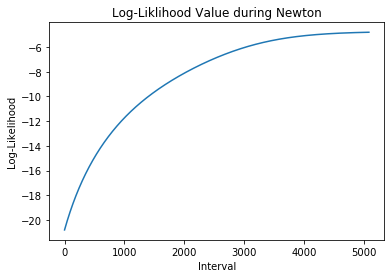

In [374]:
plt.plot(vals)
plt.title("Log-Liklihood Value during Newton")
plt.xlabel("Interval")
plt.ylabel("Log-Likelihood");

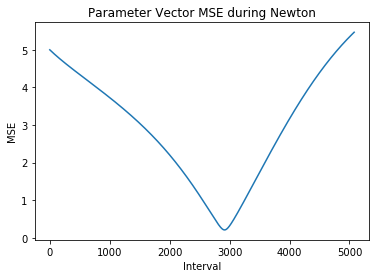

In [375]:
plt.plot(mse)
plt.title("Parameter Vector MSE during Newton")
plt.xlabel("Interval")
plt.ylabel("MSE");

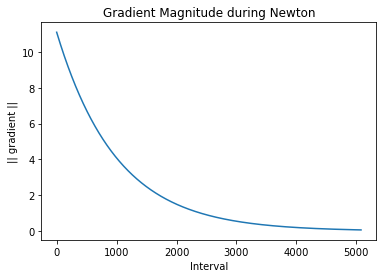

In [376]:
plt.plot(grads)
plt.title("Gradient Magnitude during Newton")
plt.xlabel("Interval")
plt.ylabel("|| gradient ||");

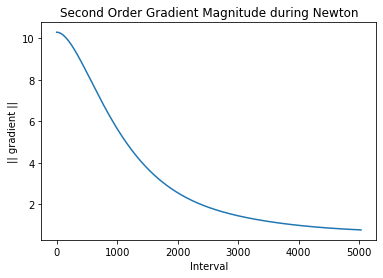

In [353]:
plt.plot(second_grads)
plt.title("Second Order Gradient Magnitude during Newton")
plt.xlabel("Interval")
plt.ylabel("|| gradient ||");

In [ ]:
X_variance = 10
ns = [10, 20, 50, 80, 200, 300, 500, 700, 1000, 5000]
mses = []
crlbs = []
for n in ns:
    m, c = run_monte_carlo(n, X_variance, mode='newton',lr=0.001, max_iter=10000)
    mses.append(m[0])
    crlbs.append(c[0])

plt.plot(ns, mses, label="MSE")
plt.plot(ns, crlbs, label="CRLB")
plt.ylabel("CRLB & MSE")
plt.xlabel("n")
plt.xscale('log')
plt.yscale('log')
plt.legend();

/Users/anuragkoul/opt/miniconda3/envs/dream-and-search/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/Users/anuragkoul/opt/miniconda3/envs/dream-and-search/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/anuragkoul/opt/miniconda3/envs/dream-and-search/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anuragkoul/opt/miniconda3/envs/dream-and-search/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [386]:
X_variance = 1
ns = [30, 60, 90]
mses1N = []
crlbs1N = []
for n in ns:
    print(n, flush=True)
    m, c = run_monte_carlo(n, X_variance, max_iter=10000, mode="newton")
    mses1N.append(m)
    crlbs1N.append(c)

30
60
90


In [ ]:
X_variance = 10
ns = [30, 60, 90]
mses10N = []
crlbs10N = []
for n in ns:
    print(n, flush=True)
    m, c = run_monte_carlo(n, X_variance, max_iter=10000, mode="newton")
    mses10N.append(m)
    crlbs10N.append(c)

30


/home/luc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/luc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Invalid
Invalid
Invalid


In [ ]:
_, (l, r) = plt.subplots(1, 2, figsize=(10,7))

l.plot(ns, mses1N, 'x--', label="MSE")
l.plot(ns, crlbs1N, label="CRLB")
l.set_title("$\sigma^2 = 1$")
l.set_xlabel("# Observations")
l.set_ylabel("CRLB & MSE")
l.legend()
l.set_xscale('log')
l.set_yscale('log')

r.plot(ns, mses10N, 'x--', label="MSE")
r.plot(ns, crlbs10N, label="CRLB")
r.set_title("$\sigma^2 = 10$")
r.set_xlabel("# Observations")
r.set_xscale('log')
r.set_yscale('log')

plt.savefig("newton_mse.png")